In [5]:
import numpy as np
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV, train_test_split

import sys, os
sys.dont_write_bytecode = True
import conditions, analysis

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

PATH = 'Output_Figures'
os.makedirs(PATH, exist_ok=True)

PATH2 = 'Output_CSV'
os.makedirs(PATH2, exist_ok=True)

In [6]:
def extract_max_min_target_cat(condition, converted):
    date, Reaction, target_name, target_temp = condition['date'], condition['Reaction'], condition['target_name'], condition['target_temp']
    data = converted['data']
    pgm_num, add_num, supp_num, CalT_num = condition['pgm_num'], condition['add_num'], condition['supp_num'], condition['CalT_num']
    print('pgm_num =', pgm_num, 'add_num =', add_num, 'supp_num =', supp_num, 'CalT_num =', CalT_num)
    drop_data_list = ['CO Yield_%', 'Catal prep', 'Reaction', 'Note']
    data = data.drop(drop_data_list, axis=1)

    max_target = pd.DataFrame(columns=data.columns, dtype='float64')
    num_loop = {}
    idx = data['Iteration']==0
    num_loop[0] = data[idx]
    max_target = max_target.append(num_loop[0].loc[num_loop[0][target_name].idxmax()], ignore_index=True)
    max_loop_num = data['Iteration'].max()

    for i in range(max_loop_num):
        idx = data['Iteration']== i+1
        num_loop[i+1] = data[idx]
        if num_loop[i+1][target_name].max() >= max_target[target_name].max():
            max_target = max_target.append(num_loop[i+1].loc[num_loop[i+1][target_name].idxmax()], ignore_index=True)
        else:
            max_target = max_target.append(max_target.loc[max_target[target_name].idxmax()], ignore_index=True)

    max_target_Ad1 = max_target['Ad1'].str.cat([max_target['Ad1_wt%'].astype(str)], sep=' ')
    max_target_Ad2 = max_target['Ad2'].str.cat([max_target['Ad2_wt%'].astype(str)], sep=' ')
    max_target_Ad3 = max_target['Ad3'].str.cat([max_target['Ad3_wt%'].astype(str)], sep=' ')
    max_target_Ad4 = max_target['Ad4'].str.cat([max_target['Ad4_wt%'].astype(str)], sep=' ')
    max_target_Ad5 = max_target['Ad5'].str.cat([max_target['Ad5_wt%'].astype(str)], sep=' ')

    max_target['Top catal.'] = max_target_Ad1.str.cat([max_target_Ad2, max_target_Ad3, max_target_Ad4,max_target_Ad5],  sep=', ').str.rstrip(' H 0.0, H 0.0')
    max_target_out = max_target.drop_duplicates()
    
    max_target_out.to_csv(f'{PATH2}/{date}_{Reaction}_best_catalysts_loop{max_loop_num+1}.csv')
    return max_target_out, max_target



def loop_CV(condition, converted):
    """_summary_
    Args:
        condition (_type_): _description_
        converted (_type_): _description_
    """
    method_list = [0, 1, 2]
    date, Reaction, data_sheet_name = condition['date'], condition['Reaction'], condition['data_sheet_name']
    pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']
    data = converted['data']
    num_loop_max = data['Iteration'].max()
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        prop_list = list(itertools.product(method_list, repeat=3))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[prop_list[i][0], prop_list[i][1], prop_list[i][2]], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}{prop_list[i][1]}{prop_list[i][2]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}{prop_list[i][1]}{prop_list[i][2]}_loop{num_loop_max}.csv')

    elif pgm_num == 0 and add_num != 0 and supp_num != 0:
        prop_list = list(itertools.product(method_list, repeat=2))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[2, prop_list[i][0], prop_list[i][1]], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop=__{prop_list[i][0]}{prop_list[i][1]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__{prop_list[i][0]}{prop_list[i][1]}_loop{num_loop_max}.csv')

    elif pgm_num != 0 and add_num == 0 and supp_num != 0:
        prop_list = list(itertools.product(method_list, repeat=2))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[prop_list[i][0], 2, prop_list[i][1]], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}__{prop_list[i][1]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}__{prop_list[i][1]}_loop{num_loop_max}.csv')

    elif pgm_num != 0 and add_num != 0 and supp_num == 0:
        prop_list = list(itertools.product(method_list, repeat=2))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[prop_list[i][0], prop_list[i][1], 2], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}{prop_list[i][1]}__', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}{prop_list[i][1]}__loop{num_loop_max}.csv')

    elif pgm_num == 0 and add_num != 0 and supp_num == 0:
        prop_list = list(itertools.product(method_list, repeat=1))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[2, prop_list[i][0], 2], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}_loop{num_loop_max}.csv')
    

In [7]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
data, feat, target = converted['data'], converted['feat'], converted['target']
max_target_out, max_target = extract_max_min_target_cat(condition, converted)

20220318 rwgs_250 all data
pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


In [8]:
loop_CV(condition, converted)

rwgs_250 Iteration = 0
prop=0 data_length= 45
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.568, MSE: 0.340, MAE: 0.444, R2: 0.225, RMSE detail (sd: 0.133, min:0.224, max:0.862)
rwgs_250 Iteration = 1
prop=0 data_length= 50
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.600, MSE: 0.378, MAE: 0.475, R2: 0.118, RMSE detail (sd: 0.133, min:0.280, max:0.866)
rwgs_250 Iteration = 2
prop=0 data_length= 58
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.530, MSE: 0.294, MAE: 0.415, R2: 0.203, RMSE detail (sd: 0.118, min:0.239, max:0.774)
rwgs_250 Iteration = 3
prop=0 data_length= 65
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.504, MSE: 0.267, MAE: 0.387, R2: 0.248, RMSE detail (sd: 0.114, min:0.246,

In [9]:
def plot_loop_CV(condition, converted):
    # Basic setups.
    plt.rcParams["mathtext.fontset"] = "stixsans"
    date, Reaction = condition['date'], condition['Reaction']
    pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']
    data = converted['data']
    num_loop_max = data['Iteration'].max()
    fig, ax = plt.subplots(4,1, facecolor='white', figsize = (15, 30))
    plt.subplots_adjust(wspace=0.2, hspace=0.12)
    # Read csv files.

    CV_prop0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0_loop{num_loop_max}.csv')
    CV_prop1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1_loop{num_loop_max}.csv')
    CV_prop2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2_loop{num_loop_max}.csv')

    ax[0].plot(CV_prop0['tes_rmse'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
    ax[0].plot(CV_prop1['tes_rmse'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
    ax[0].plot(CV_prop2['tes_rmse'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
    ax[1].plot(CV_prop0['tes_mse'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
    ax[1].plot(CV_prop1['tes_mse'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
    ax[1].plot(CV_prop2['tes_mse'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
    ax[2].plot(CV_prop0['tes_mae'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
    ax[2].plot(CV_prop1['tes_mae'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
    ax[2].plot(CV_prop2['tes_mae'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
    ax[3].plot(CV_prop0['tes_r2'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
    ax[3].plot(CV_prop1['tes_r2'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
    ax[3].plot(CV_prop2['tes_r2'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
    
    if num_loop_max <= 10:
        x_notch_num = 1
    elif num_loop_max > 10 and num_loop_max <= 20:
        x_notch_num = 2
    elif num_loop_max > 20 and num_loop_max <= 30:
        x_notch_num = 3
    elif num_loop_max > 30 and num_loop_max <= 50:
        x_notch_num = 5
    elif num_loop_max > 50:
        x_notch_num = 10
    
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        ncols = 2
    else:
        ncols = 1

    ax[0].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[0].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[0].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[0].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[0].set_ylim(auto=True)
    ax[0].set_xlabel('Iteration', fontsize=14)
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300' or Reaction == 'rwgs_250_1wt':
        ax[0].set_ylabel('RMSE (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=14)
    elif Reaction == 'CH3OH':
        ax[0].set_ylabel('RMSE (mmol $g^{{-}1}$ $h^{{-}1}$)', fontsize=14)
    else:
        ax[0].set_ylabel('RMSE (℃)', fontsize=14)
    
    ax[1].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[1].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[1].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[1].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[1].set_ylim(auto=True)
    ax[1].set_xlabel('Iteration', fontsize=14)
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300':
        ax[1].set_ylabel('MSE (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)$^{2}$', fontsize=14)
    elif Reaction == 'CH3OH':
        ax[1].set_ylabel('MSE (mmol $g^{{-}1}$ $h^{{-}1})^{2}$', fontsize=14)
    else:
        ax[1].set_ylabel('MSE $(℃^{2})$', fontsize=14)
    
    ax[2].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[2].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[2].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[2].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[2].set_ylim(auto=True)
    ax[2].set_xlabel('Iteration', fontsize=14)
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300' or Reaction == 'rwgs_250_1wt':
        ax[2].set_ylabel('MAE (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=14)
    elif Reaction == 'CH3OH':
        ax[2].set_ylabel('MAE (mmol $g^{{-}1}$ $h^{{-}1}$)', fontsize=14)
    else:
        ax[2].set_ylabel('MAE (℃)', fontsize=14)

    ax[3].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[3].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[3].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[3].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[3].set_ylim(auto=True)
    ax[3].set_xlabel('Iteration', fontsize=14)
    ax[3].set_ylabel('$\it{R}$$^{2}$ value', fontsize=14)

    plt.savefig(f'{PATH}/{date}_{Reaction}_CV-plot_4-kinds_loop{num_loop_max}_fin.png', dpi=600, bbox_inches='tight')


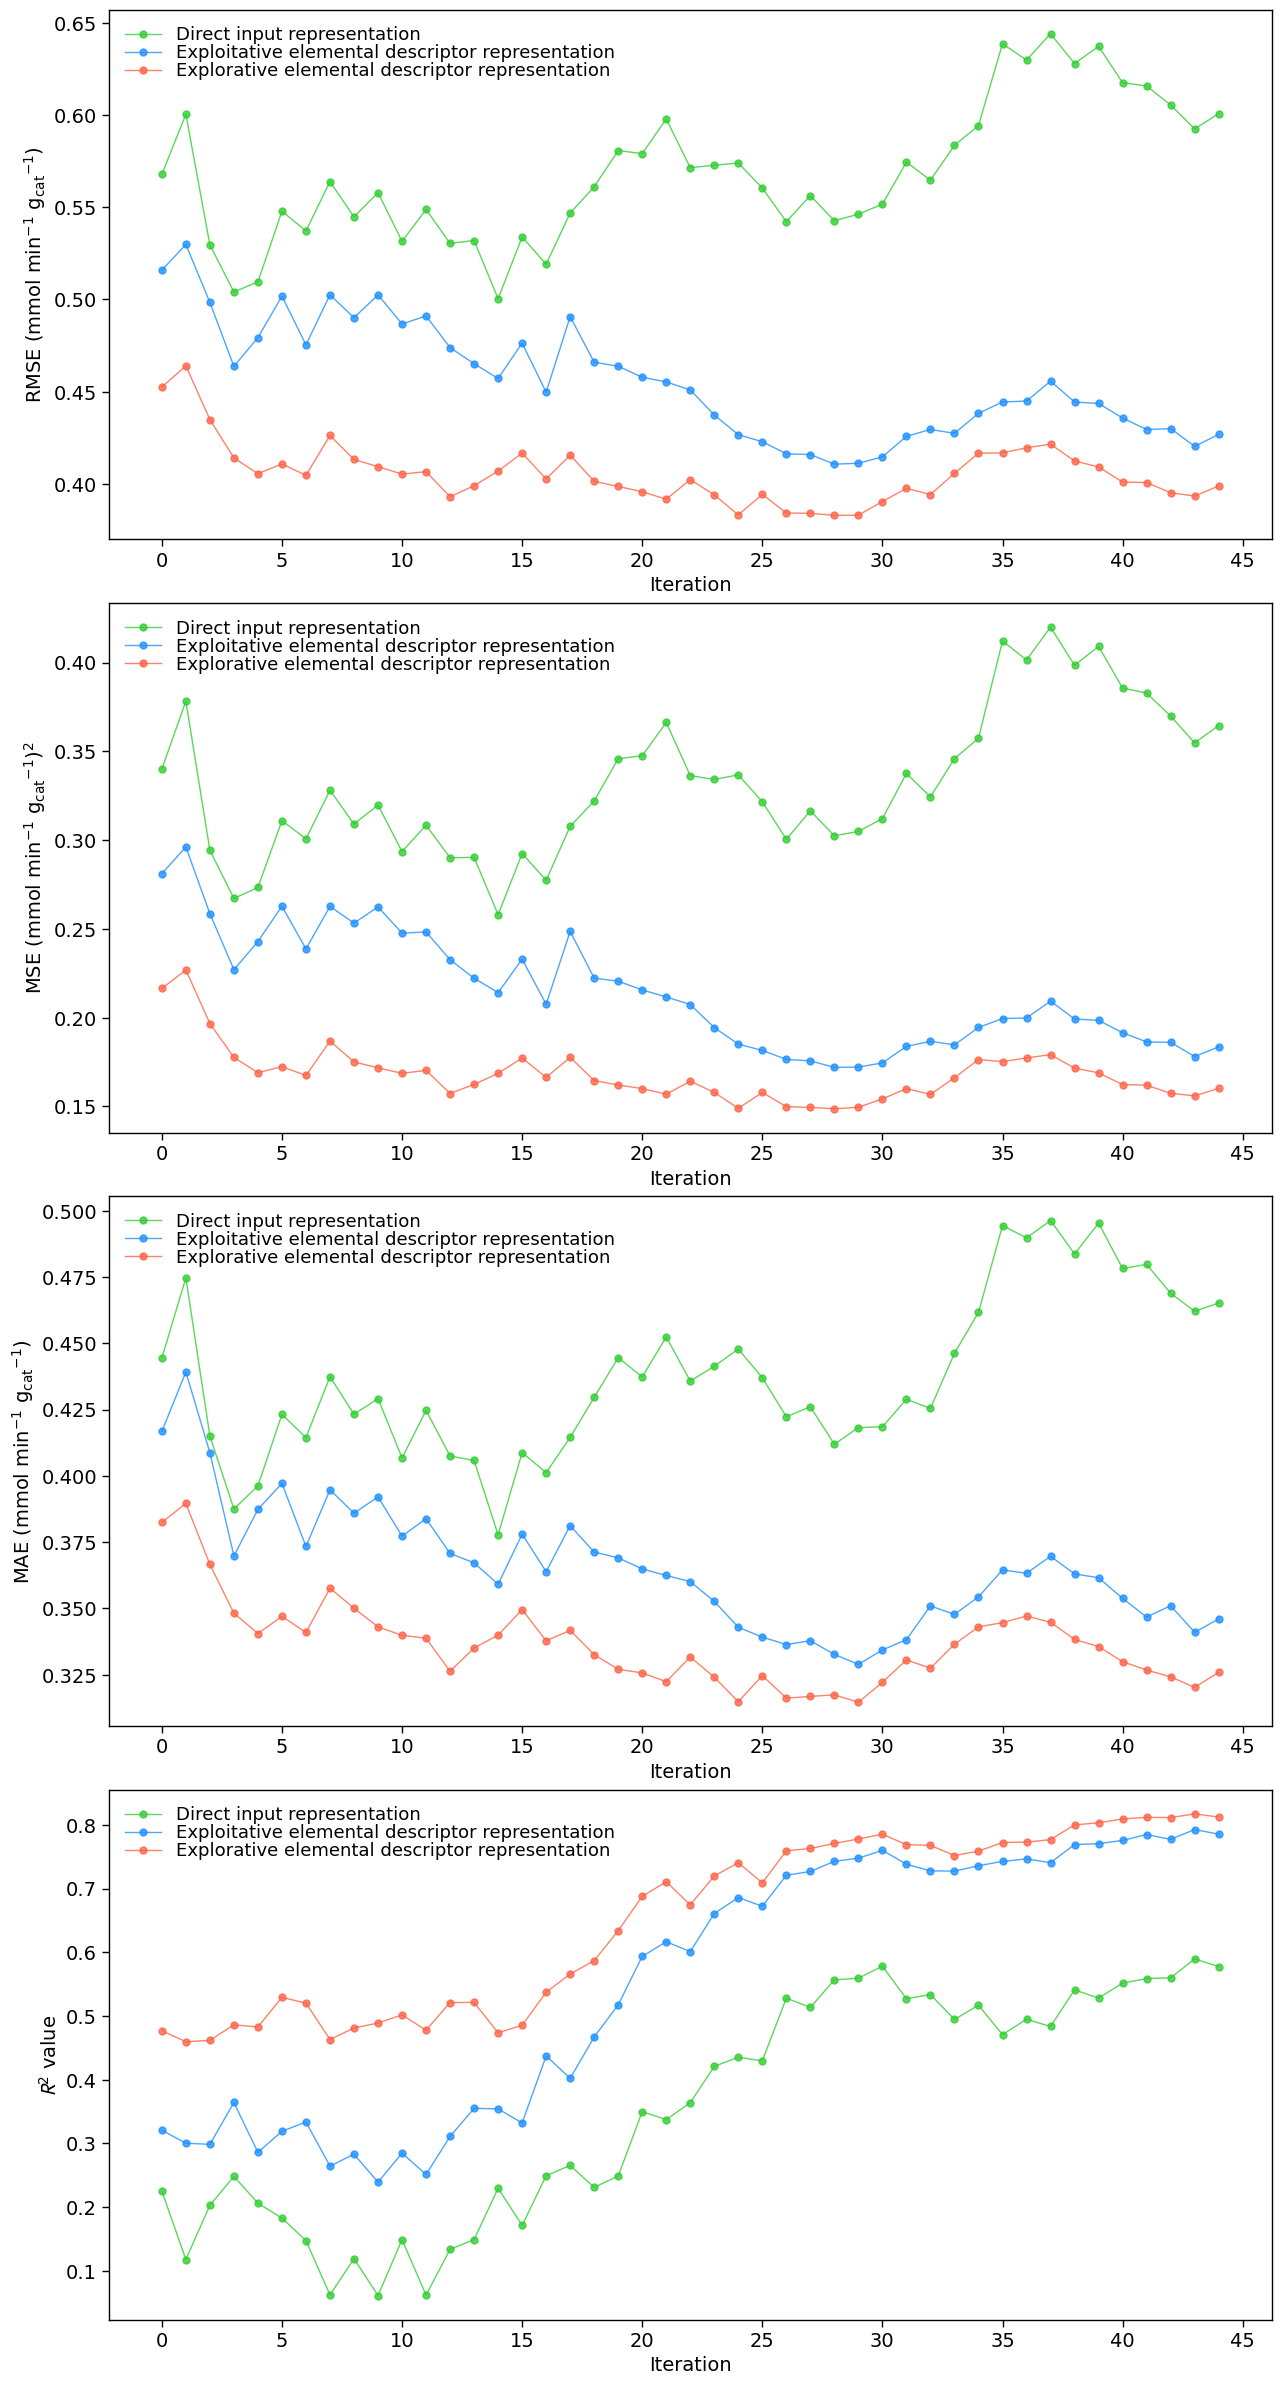

In [10]:
plot_loop_CV(condition, converted)

In [13]:
def plot_r2_and_target(condition, converted):
    # Basic setups.
    plt.rcParams["mathtext.fontset"] = "stixsans"
    date, Reaction = condition['date'], condition['Reaction']
    data, desc  = converted['data'], converted['desc']
    target_name = condition['target_name']
    pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']

    num_loop_max = data['Iteration'].max()
    fig = plt.figure(facecolor='white', figsize=(15,18))
    # GridSpec Make objects
    gs = fig.add_gridspec(2, 3, width_ratios=[1,1,1], height_ratios=[1,2])
    plt.subplots_adjust(wspace=0.2, hspace=0.12)
    # Axes Make objects
    ax1 = fig.add_subplot(gs[0,:3])
    ax2 = fig.add_subplot(gs[1,:3])
    
    # Read csv files and plot R2 values.
    CV_prop0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0_loop{num_loop_max}.csv')
    CV_prop1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1_loop{num_loop_max}.csv')
    CV_prop2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2_loop{num_loop_max}.csv')
    
    ax1.plot(CV_prop0['tes_r2'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
    ax1.plot(CV_prop1['tes_r2'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
    ax1.plot(CV_prop2['tes_r2'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')

    Iteration = {}
    idx = data['Iteration']==0
    Iteration[0] = data[idx]
    Iteration[0] = Iteration[0].drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1','Catal prep', 'Reaction', 'Note', 'Iteration'], axis=1)
    max_iteration = data['Iteration'].max()
    data_count = data.drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1','Catal prep', 'Reaction', 'Note', 'Iteration'], axis=1)
    data_elem_num_0 = pd.DataFrame(index=desc.index, columns=['Num_elem']).fillna(0)

    for i in range(len(Iteration[0])):
        for j in range(pgm_num):
            if Iteration[0].loc[i, f'PGM{j+1}_wt%'] > 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'PGM{j+1}']] += 1
            elif Iteration[0].loc[i, f'PGM{j+1}_wt%'] == 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'PGM{j+1}']] += 0
        for j in range(add_num):
            if Iteration[0].loc[i, f'Ad{j+1}_wt%'] > 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'Ad{j+1}']] += 1
            elif Iteration[0].loc[i, f'Ad{j+1}_wt%'] == 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'Ad{j+1}']] += 0

    data_elem_num_0 = data_elem_num_0[data_elem_num_0['Num_elem'] != 0]
    data_elem_num_0.to_csv(f'{PATH2}/data_elem_num_0.csv', header=None)
    elem_list_original = list(data_elem_num_0.index)

    data_elem_num_now = pd.DataFrame(index=desc.index, columns=['Num_elem']).fillna(0)
    for i in range(len(data)):
        for j in range(pgm_num):
            if data_count.loc[i, f'PGM{j+1}_wt%'] > 0:
                data_elem_num_now.loc[data_count.loc[i, f'PGM{j+1}']] += 1
            elif data_count.loc[i, f'PGM{j+1}_wt%'] == 0:
                data_elem_num_now.loc[data_count.loc[i, f'PGM{j+1}']] += 0
        for j in range(add_num):
            if data_count.loc[i, f'Ad{j+1}_wt%'] > 0:
                data_elem_num_now.loc[data_count.loc[i, f'Ad{j+1}']] += 1
            elif data_count.loc[i, f'Ad{j+1}_wt%'] == 0:
                data_elem_num_now.loc[data_count.loc[i, f'Ad{j+1}']] += 0

    data_elem_num_now = data_elem_num_now[data_elem_num_now['Num_elem'] != 0]
    data_elem_num_now.to_csv(f'{PATH2}/data_elem_num_{max_iteration}.csv', header=None)
    elem_list_now = list(data_elem_num_now.index)
    new_elem_list = list(set(elem_list_now) - set(elem_list_original))

    if num_loop_max <= 10:
        x_notch_num = 1
    elif num_loop_max > 10 and num_loop_max <= 20:
        x_notch_num = 2
    elif num_loop_max > 20 and num_loop_max <= 30:
        x_notch_num = 3
    elif num_loop_max > 30 and num_loop_max <= 50:
        x_notch_num = 5
    elif num_loop_max > 50:
        x_notch_num = 10
    
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        ncols = 2
    else:
        ncols = 1
        
    ax1.set_xticks(np.arange(0, num_loop_max+3, x_notch_num))
    ax1.set_xlim(-0.5, num_loop_max+1)
    ax1.tick_params(direction="out", length=6, colors="black", labelsize=16)

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax1.legend(fontsize=18, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax1.legend(fontsize=18, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax1.set_ylim(auto=True)
    ax1.set_xlabel('Iteration', fontsize=18)
    ax1.set_ylabel('$\it{R}$$^{2}$ value', fontsize=19)
    ax1.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=0.5, markerscale=1.2, fontsize=16, frameon=False)
    
    Top_catal = data[data[target_name] == data[target_name].max()]
    data = data.drop(Top_catal.index, axis=0)

    data_Mo = pd.concat([data[data['Ad1'] == 'Mo'], data[data['Ad2'] == 'Mo'], data[data['Ad3'] == 'Mo'], data[data['Ad4'] == 'Mo'], data[data['Ad5'] == 'Mo']], axis=0).drop_duplicates()
    data_MoRb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Rb'], data_Mo[data_Mo['Ad2'] == 'Rb'], data_Mo[data_Mo['Ad3'] == 'Rb'], data_Mo[data_Mo['Ad4'] == 'Rb'], data_Mo[data_Mo['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    data_MoNb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Nb'], data_Mo[data_Mo['Ad2'] == 'Nb'], data_Mo[data_Mo['Ad3'] == 'Nb'], data_Mo[data_Mo['Ad4'] == 'Nb'], data_Mo[data_Mo['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    data_MoRbNb = pd.concat([data_MoRb[data_MoRb['Ad1'] == 'Nb'], data_MoRb[data_MoRb['Ad2'] == 'Nb'], data_MoRb[data_MoRb['Ad3'] == 'Nb'], data_MoRb[data_MoRb['Ad4'] == 'Nb'], data_MoRb[data_MoRb['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_MoRbNb[data_MoRbNb[f'Ad{i+1}'] == 'Ba']
        data_MoRbNb = data_MoRbNb.drop(drop_catal.index, axis=0)
    data_MoRbNb = data_MoRbNb.drop_duplicates(keep=False)
    
    data_MoBa = pd.concat([data_Mo[data_Mo['Ad1'] == 'Ba'], data_Mo[data_Mo['Ad2'] == 'Ba'], data_Mo[data_Mo['Ad3'] == 'Ba'], data_Mo[data_Mo['Ad4'] == 'Ba'], data_Mo[data_Mo['Ad5'] == 'Ba']], axis=0).drop_duplicates()
    data_MoBaNb = pd.concat([data_MoBa[data_MoBa['Ad1'] == 'Nb'], data_MoBa[data_MoBa['Ad2'] == 'Nb'], data_MoBa[data_MoBa['Ad3'] == 'Nb'], data_MoBa[data_MoBa['Ad4'] == 'Nb'], data_MoBa[data_MoBa['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_MoBaNb[data_MoBaNb[f'Ad{i+1}'] == 'Rb']
        data_MoBaNb = data_MoBaNb.drop(drop_catal.index, axis=0)
    data_MoBaNb = data_MoBaNb.drop_duplicates(keep=False)

    data_MoBaRb = pd.concat([data_MoBa[data_MoBa['Ad1'] == 'Rb'], data_MoBa[data_MoBa['Ad2'] == 'Rb'], data_MoBa[data_MoBa['Ad3'] == 'Rb'], data_MoBa[data_MoBa['Ad4'] == 'Rb'], data_MoBa[data_MoBa['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_MoBaRb[data_MoBaRb[f'Ad{i+1}'] == 'Nb']
        data_MoBaRb = data_MoBaRb.drop(drop_catal.index, axis=0)
    data_MoBaRb = data_MoBaRb.drop_duplicates(keep=False)
    
    data_Ba = pd.concat([data[data['Ad1'] == 'Ba'], data[data['Ad2'] == 'Ba'], data[data['Ad3'] == 'Ba'], data[data['Ad4'] == 'Ba'], data[data['Ad5'] == 'Ba']], axis=0).drop_duplicates()
    data_BaRb = pd.concat([data_Ba[data_Ba['Ad1'] == 'Rb'], data_Ba[data_Ba['Ad2'] == 'Rb'], data_Ba[data_Ba['Ad3'] == 'Rb'], data_Ba[data_Ba['Ad4'] == 'Rb'], data_Ba[data_Ba['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    data_BaRbNb = pd.concat([data_BaRb[data_BaRb['Ad1'] == 'Nb'], data_BaRb[data_BaRb['Ad2'] == 'Nb'], data_BaRb[data_BaRb['Ad3'] == 'Nb'], data_BaRb[data_BaRb['Ad4'] == 'Nb'], data_BaRb[data_BaRb['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_BaRbNb[data_BaRbNb[f'Ad{i+1}'] == 'Mo']
        data_BaRbNb = data_BaRbNb.drop(drop_catal.index, axis=0)
    data_BaRbNb = data_BaRbNb.drop_duplicates(keep=False)

    drop_catal_list = list(data_BaRbNb.index) + list(data_MoBaNb.index) + list(data_MoBaRb.index) + list(data_MoRbNb.index)
    data = data.drop(drop_catal_list, axis=0)
    data_Mo = pd.concat([data[data['Ad1'] == 'Mo'], data[data['Ad2'] == 'Mo'], data[data['Ad3'] == 'Mo'], data[data['Ad4'] == 'Mo'], data[data['Ad5'] == 'Mo']], axis=0).drop_duplicates()
    data_MoBa = pd.concat([data_Mo[data_Mo['Ad1'] == 'Ba'], data_Mo[data_Mo['Ad2'] == 'Ba'], data_Mo[data_Mo['Ad3'] == 'Ba'], data_Mo[data_Mo['Ad4'] == 'Ba'], data_Mo[data_Mo['Ad5'] == 'Ba']], axis=0).drop_duplicates()
    data = data.drop(data_MoBa.index, axis=0)
    data_Mo = data_Mo.drop(data_MoBa.index, axis=0)
    data_MoRb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Rb'], data_Mo[data_Mo['Ad2'] == 'Rb'], data_Mo[data_Mo['Ad3'] == 'Rb'], data_Mo[data_Mo['Ad4'] == 'Rb'], data_Mo[data_Mo['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    data = data.drop(data_MoRb.index, axis=0)
    data_Mo = data_Mo.drop(data_MoRb.index, axis=0)
    data_MoNb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Nb'], data_Mo[data_Mo['Ad2'] == 'Nb'], data_Mo[data_Mo['Ad3'] == 'Nb'], data_Mo[data_Mo['Ad4'] == 'Nb'], data_Mo[data_Mo['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    data = data.drop(data_MoNb.index, axis=0)
    data_Mo = data_Mo.drop(data_MoNb.index, axis=0)
    data = data.drop(data_Mo.index, axis=0).reset_index()

    # Max Target value
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_250_1wt':
        ax2.scatter(Top_catal['Iteration'], Top_catal[target_name], zorder=3, s=40, marker='D', alpha=1, color='red')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=1, color='red', label='Rb-Ba-Mo-Nb')
        
        for i in range(len(new_elem_list)):
            data_MoBaRb_new_elems = pd.concat([data_MoBaRb[data_MoBaRb['Ad1'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad2'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad3'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad4'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBaRb = data_MoBaRb.drop(data_MoBaRb_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_MoBaRb_new_elems['Iteration'], data_MoBaRb_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='blue')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.4, color='blue', label='Rb-Ba-Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='blue')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_MoBaRb_conv_elems = pd.concat([data_MoBaRb[data_MoBaRb['Ad1'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad2'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad3'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad4'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBaRb = data_MoBaRb.drop(data_MoBaRb_conv_elems.index, axis=0)
            x_conv, y_conv = data_MoBaRb_conv_elems['Iteration'], data_MoBaRb_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='blue')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='blue')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        ax2.scatter(data_BaRbNb['Iteration'], data_BaRbNb[target_name], zorder=3, s=40, marker='D', alpha=0.4, color='blueviolet')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.4, color='blueviolet', label='Rb-Ba-Nb')
        ax2.scatter(data_MoRbNb['Iteration'], data_MoRbNb[target_name], zorder=3, s=40, marker='D', alpha=0.4, color='green')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.4, color='green', label='Rb-Mo-Nb')
        ax2.scatter(data_MoBaNb['Iteration'], data_MoBaNb[target_name], zorder=3, s=40, marker='D', alpha=0.4, color='orangered')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.4, color='orangered', label='Ba-Mo-Nb')
        #
        for i in range(len(new_elem_list)):
            data_MoRb_new_elems = pd.concat([data_MoRb[data_MoRb['Ad1'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad2'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad3'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad4'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_MoRb = data_MoRb.drop(data_MoRb_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_MoRb_new_elems['Iteration'], data_MoRb_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='lime')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.4, color='lime', label='Rb-Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='lime')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_MoRb_conv_elems = pd.concat([data_MoRb[data_MoRb['Ad1'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad2'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad3'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad4'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_MoRb = data_MoRb.drop(data_MoRb_conv_elems.index, axis=0)
            x_conv, y_conv = data_MoRb_conv_elems['Iteration'], data_MoRb_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='lime')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='lime')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        #
        for i in range(len(new_elem_list)):
            data_MoBa_new_elems = pd.concat([data_MoBa[data_MoBa['Ad1'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad2'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad3'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad4'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBa = data_MoBa.drop(data_MoBa_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_MoBa_new_elems['Iteration'], data_MoBa_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=4, s=40, marker='D', alpha=0.5, color='dodgerblue')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.5, color='dodgerblue', label='Ba-Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.5, color='dodgerblue')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_MoBa_conv_elems = pd.concat([data_MoBa[data_MoBa['Ad1'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad2'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad3'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad4'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBa = data_MoBa.drop(data_MoBa_conv_elems.index, axis=0)
            x_conv, y_conv = data_MoBa_conv_elems['Iteration'], data_MoBa_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.5, color='dodgerblue')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.5, color='dodgerblue')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        ax2.scatter(data_MoNb['Iteration'], data_MoNb[target_name], zorder=3, s=40, marker='D', alpha=0.6, color='teal')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.6, color='teal', label='Mo-Nb')
        
        #
        for i in range(len(new_elem_list)):
            data_Mo_new_elems = pd.concat([data_Mo[data_Mo['Ad1'] == new_elem_list[i]], data_Mo[data_Mo['Ad2'] == new_elem_list[i]], data_Mo[data_Mo['Ad3'] == new_elem_list[i]], data_Mo[data_Mo['Ad4'] == new_elem_list[i]], data_Mo[data_Mo['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_Mo = data_Mo.drop(data_Mo_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_Mo_new_elems['Iteration'], data_Mo_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='hotpink')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.4, color='hotpink', label='Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='hotpink')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_Mo_conv_elems = pd.concat([data_Mo[data_Mo['Ad1'] == elem_list_original[i]], data_Mo[data_Mo['Ad2'] == elem_list_original[i]], data_Mo[data_Mo['Ad3'] == elem_list_original[i]], data_Mo[data_Mo['Ad4'] == elem_list_original[i]], data_Mo[data_Mo['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_Mo = data_Mo.drop(data_Mo_conv_elems.index, axis=0)
            x_conv, y_conv = data_Mo_conv_elems['Iteration'], data_Mo_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=30, marker='o', alpha=0.4, color='hotpink')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=30, marker='o', alpha=0.4, color='hotpink')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        for i in range(len(new_elem_list)):
            data_new_elems = pd.concat([data[data['Ad1'] == new_elem_list[i]], data[data['Ad2'] == new_elem_list[i]], data[data['Ad3'] == new_elem_list[i]], data[data['Ad4'] == new_elem_list[i]], data[data['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data = data.drop(data_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_new_elems['Iteration'], data_new_elems[target_name]
            if i == 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_new) != 0:
                pass
            
        for i in range(len(elem_list_original)):
            data_conv_elems = pd.concat([data[data['Ad1'] == elem_list_original[i]], data[data['Ad2'] == elem_list_original[i]], data[data['Ad3'] == elem_list_original[i]], data[data['Ad4'] == elem_list_original[i]], data[data['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data = data.drop(data_conv_elems.index, axis=0)
            x_conv, y_conv = data_conv_elems['Iteration'], data_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_conv) != 0:
                pass

        #ax2.plot(max_target[target_name], zorder=2, color='k', alpha=1, linewidth=1, label='Max CO formation rate')
        ax2.step(np.arange(0, 45, 1), max_target[target_name], where='post', zorder=2, color='orangered', alpha=0.8, linewidth=2.5, label='Max CO formation rate')
        ax2.tick_params(direction="out", length=6, colors="black", labelsize=16)

        #plt.ylim(2.4, 4)
        ax2.set_ylim(0, 4.5)
        data, desc  = converted['data'], converted['desc']
        ax2.set_xticks(np.arange(0, num_loop_max+3, x_notch_num))
        ax2.set_xlim(-0.5, num_loop_max+1)
        ax2.hlines(2.554, 0, data['Iteration'].max(), color='navy', linestyle='dashed', lw=2, zorder=1, alpha=0.7)
        ax2.hlines(0.45, data['Iteration'].max()-10, data['Iteration'].max()-7.5, color='navy', linestyle='dashed')
        ax2.text(data['Iteration'].max()-7, 0.41, "$Pt(3)/Mo(10)/TiO_{2}$", color='k', fontsize=16)

        ax2.hlines(0.870, 0, data['Iteration'].max(), color='darkgreen', linestyle='dashdot', lw=2, zorder=1, alpha=0.7)
        ax2.hlines(0.25, data['Iteration'].max()-10, data['Iteration'].max()-7.5, color='darkgreen', linestyle='dashdot')
        ax2.text(data['Iteration'].max()-7, 0.21, "$Cu/ZnO/Al_{2}O_{3}$", color='k', fontsize=16)

        ax2.set_xlabel('Iteration', fontsize=18)
        ax2.set_ylabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=18)
        ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, markerscale=1,  fontsize=16, frameon=False)
        plt.savefig(f'{PATH}/{date}_{Reaction}_R2_and_Stairs_plot_loop{num_loop_max}_fin.png', dpi=600, bbox_inches='tight')
        

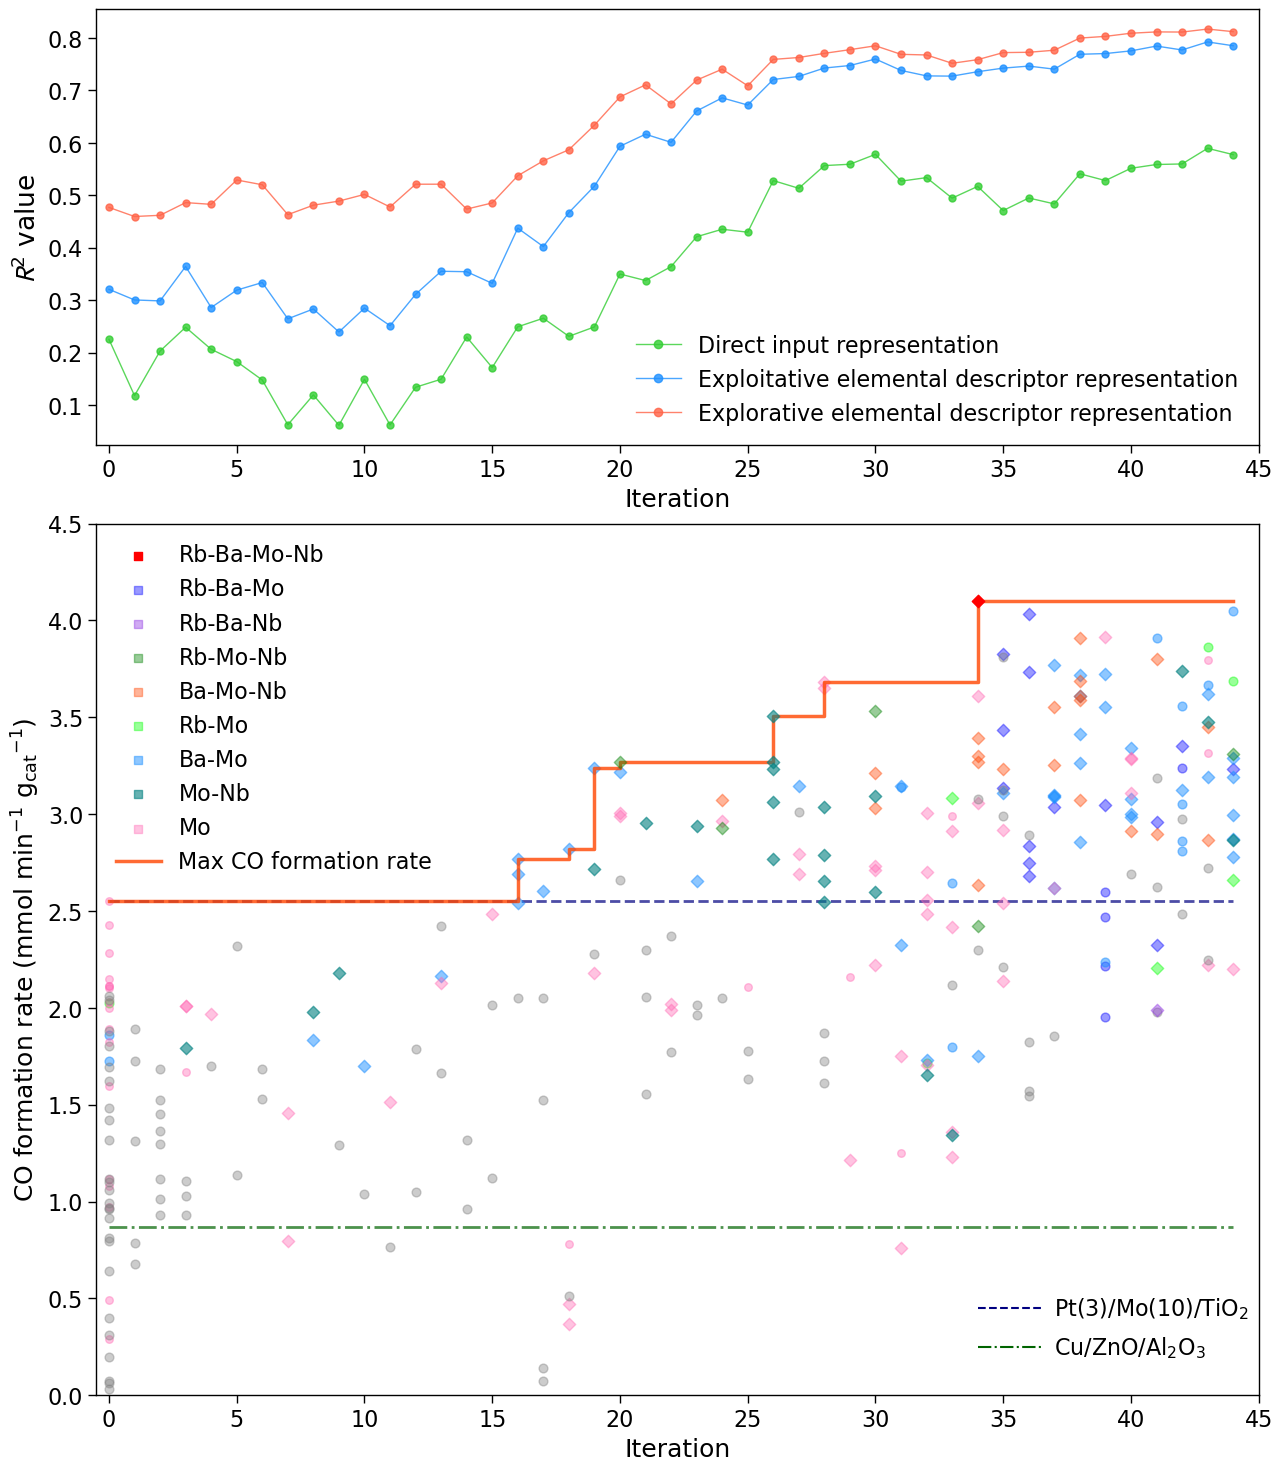

In [14]:
plot_r2_and_target(condition, converted)